In [262]:
import numpy as np
import numpy.typing as npt

In [263]:
from PIL import Image
import os

class_names = ['uniform', 'horizontal', 'vertical', 'diagonal']
class_index = {name: i for i, name in enumerate(class_names)}


def load_dataset(folder_path: str) -> tuple[npt.NDArray, npt.NDArray]:
    X, y = [], []
    for filename in os.listdir(folder_path):
        if filename.lower().endswith('.jpeg'):
            path = os.path.join(folder_path, filename)
            class_name = filename.split('_')[0]
            img = Image.open(path)
            normalized_img = np.asarray(img, dtype=np.float32) / 255.0
            X.append(normalized_img.flatten())
            y.append(np.eye(len(class_names))[class_index[class_name]])

    return np.array(X), np.array(y)



In [264]:
def sigmoid(z: npt.NDArray) -> npt.NDArray:
    return 1 / (1 + np.exp(-z))


def sigmoid_derivative(z: npt.NDArray) -> npt.NDArray:
    sig = sigmoid(z)
    return sig * (1 - sigmoid(z))


def softmax(z: npt.NDArray) -> npt.NDArray:
    z = np.array(z)
    exp_z = np.exp(z - np.max(z))
    return exp_z / np.sum(exp_z)


def relu(z: npt.NDArray) -> npt.NDArray:
    return np.maximum(0, z)


def relu_derivative(z: npt.NDArray) -> npt.NDArray:
    return (z > 0).astype(float)

In [265]:
def cross_entropy(y_pred: npt.NDArray, y_target: npt.NDArray) -> float:
    return -np.sum(y_target * np.log(y_pred + 1e-15))

In [266]:
class Layer:
    def __init__(self, input_dim: int, units: int, activation, activation_deriv):
        self.activation = activation
        self.activation_deriv = activation_deriv
        self.W = np.random.rand(units, input_dim) * 0.1
        self.b = np.zeros((units, 1))

    def forward(self, x: npt.NDArray) -> npt.NDArray:
        self.x = x
        self.z = self.W @ x + self.b
        self.a = self.activation(self.z)

        return self.a

    def backward(self, grad_output: npt.NDArray, learning_rate: float) -> npt.NDArray:
        dz = grad_output * self.activation_deriv(self.z)
        dW = dz @ self.x.T
        db = dz
        dx = self.W.T @ dz
        self.W -= learning_rate * dW
        self.b -= learning_rate * db

        return dx


In [267]:
class NeuralNetwork:
    def __init__(self, layers: list[Layer]):
        self.layers = layers

    def forward(self, x: npt.NDArray) -> npt.NDArray:
        for layer in self.layers:
            x = layer.forward(x)

        return x

    def backward(self, grad_output: npt.NDArray, learning_rate: float) -> None:
        for layer in reversed(self.layers):
            grad_output = layer.backward(grad_output, learning_rate)

    def train(self, x_train: npt.NDArray, y_train: npt.NDArray, epochs: int, learning_rate: float) -> None:
        for epoch in range(epochs):
            total_loss: float = 0.

            for x, y in zip(x_train, y_train):
                # Reshaping to column vector.
                x: npt.NDArray = x.reshape(-1, 1)
                y: npt.NDArray = y.reshape(-1, 1)
                # Forward pass
                output = self.forward(x)
                # Loss
                loss = cross_entropy(output, y)
                total_loss += loss
                # Backpropagation
                grad_output = output - y
                self.backward(grad_output, learning_rate)

            if epoch % 100 == 0 or epoch + 1 == epochs:
                print(f"Epoch {epoch}: loss = {total_loss}")

    def predict(self, x: npt.NDArray) -> npt.NDArray:
        x = x.reshape(-1, 1)
        output = self.forward(x)
        return output

In [268]:
X, y = load_dataset('./dataset')

test_ratio = 0.2
num_samples = X.shape[0]
num_test = int(num_samples * test_ratio)

indices = np.random.permutation(num_samples)

test_idx = indices[:num_test]
train_idx = indices[num_test:]

X_train = X[train_idx]
y_train = y[train_idx]
X_test = X[test_idx]
y_test = y[test_idx]

In [269]:
layers_sigmoid = [
    Layer(4, 4, sigmoid, sigmoid_derivative),
    Layer(4, 4, sigmoid, sigmoid_derivative),
    Layer(4, 4, softmax, lambda x: 1)
]

layers_relu = [
    Layer(4, 6, relu, relu_derivative),
    Layer(6, 4, relu, relu_derivative),
    Layer(4, 4, softmax, lambda x: 1)
]

nn = NeuralNetwork(layers_relu)
nn.train(X_train, y_train, 1000, 0.01)


Epoch 0: loss = 4444.185650725837
Epoch 100: loss = 3305.5974972951885
Epoch 200: loss = 180.75964856276218
Epoch 300: loss = 76.35309726345228
Epoch 400: loss = 54.37207604235278
Epoch 500: loss = 41.88661185815481
Epoch 600: loss = 55.653857159640914
Epoch 700: loss = 51.69390524101839
Epoch 800: loss = 26.62681756618174
Epoch 900: loss = 33.68742152318735
Epoch 999: loss = 27.64462880544681


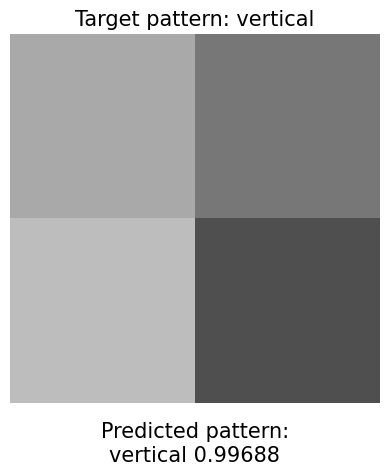

In [283]:
import matplotlib.pyplot as plt
from PIL import Image

rand_sample = np.random.randint(0, X_test.shape[0])
sample_class = class_names[np.argmax(y_test[rand_sample])]
sample_img = Image.fromarray(X_test[rand_sample].reshape((2, 2)) * 255.0)

output = nn.predict(X_test[rand_sample])
pred_class = class_names[np.argmax(output)]
confidence = output[np.argmax(output)].item()

plt.imshow(sample_img, cmap='grey', vmin=0, vmax=255)
plt.title(f'Target pattern: {sample_class}', fontsize=15)
plt.text(0.5, 1.6, f'Predicted pattern:\n{pred_class} {confidence:.5f}', fontsize=15, ha='center', va='top')
plt.axis('off')
plt.show()

In [271]:
def accuracy(model, X: npt.NDArray, y):
    correct = 0
    total = X.shape[0]

    for x, target in zip(X, y):
        output = model.predict(x)
        predicted_class = np.argmax(output)
        target_class = np.argmax(target)
        if predicted_class == target_class:
            correct += 1

    return correct / total


print(accuracy(nn, X_test, y_test))

0.9925


In [272]:
def precision(model, X, y, n_classes):
    tp = np.zeros(n_classes)
    tf = np.zeros(n_classes)

    for x, target in zip(X, y):
        output = model.predict(x)
        y_pred = np.argmax(output)
        y_target = np.argmax(target)

        if y_pred == y_target:
            tp[y_pred] += 1
        else:
            tf[y_pred] += 1

    precision: list[float] = []

    for i in range(n_classes):
        if tp[i] + tf[i] == 0:
            precision.append(0.0)
        else:
            precision.append(float(tp[i] / (tp[i] + tf[i])))

    return precision


print(precision(nn, X_test, y_test, 4))

[0.9942857142857143, 0.9913419913419913, 0.9854368932038835, 1.0]


In [ ]:
def confusion_matrix(model, X, y, n_classes):
    ...